# Previsão de Faturamento - Soma de previsões de produtos modelados individualmente.

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento total mês a mês, somando cada modelo de cada produto

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics, py_scripts.models

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Importação de modelos

Inicialmente, vamos fazer uns set-ups:

In [3]:
modelo = {}
serie_treino = {}
metricas = {}

Para cada produto, vamos importar o modelo associado (da pasta [`models`](../models/)).

In [4]:
for produto in produtos:
    produto_  = produto.split('_')[0]
    with open(fr'../models/produto_{produto_}.model', 'rb') as modelo_arq:
        unpickler = pickle.Unpickler(modelo_arq)
        modelo_dict = unpickler.load()
        modelo[produto] = modelo_dict['modelo']
        serie_treino[produto] = modelo_dict['serie_treino']


## Modelo total

### Separação entre dados de treino e de teste

Primeiramente, vamos extrair as somas de todos os faturamentos:

In [5]:
fat_total = tswide.sum(axis = 'columns')

Vamos fazer uma separação entre dados de treino e de teste para aferirmos a acurácia do modelo final.

Os modelos exportados dos notebooks individuais (arquivos `.pickle`) já estão previamente ajustados com dados de treino particulares.

**É necessário que o conjunto de teste para todos os produtos seja igual, de forma que possamos somá-los**. 

Dessa forma, o conjunto de teste de todos os modelos será composto dos faturamentos nos meses que não estão contidas em nenhum conjunto de treino.

Por exemplo: dentre todos os conjuntos de treino, o término mais próximo do presente é em dezembro de 2020. Logo, **o conjunto de teste (que será aplicado para todos os produtos) conterá os faturamentos de janeiro de 2021 para frente**.

Vamos ver como podemos implementar isso. Primeiramente, vamos gerar predições para todos os modelos.

In [6]:
# construimos um dataframe onde ficarão as predições individuais
preds = pd.DataFrame([], columns = produtos)

colsmult = pd.MultiIndex.from_product((produtos, ['lb', 'ub']))
preds_ci = pd.DataFrame([], columns = colsmult)

# maior data contida nos dados
max_date = fat_total.index[-1]

for produto in produtos:
    # maior data de cada conjunto de treino
    train_right_bound = serie_treino[produto].index[-1]

    # construimos o índice de datas do conjunto de teste de cada produto: 
    # range entre mês após o último contido no conjunto de treino e mês final
    idx_test = pd.date_range(start = train_right_bound + dt.timedelta(days = 1), end = max_date, freq = 'MS')

    # geramos a predição para cada produto. Essa predição vem em um np.array
    # como queremos o intervalo de confiança, o resultado da função é uma tupla com
    #    - o array da predição média
    #    - um array com duas colunas contendo o lower bound e o upper bound
    arr_pred_all = modelo[produto].predict(n_periods = idx_test.shape[0], return_conf_int = True)

    # primeiro trataremos das médias
    arr_pred = arr_pred_all[0]
    
    # convertemos o array para Series
    pred = pd.Series(arr_pred, index = idx_test)
    pred.name = 'predicted_mean'

    # adicionamos a Series ao DataFrame `preds`
    preds[produto] = pred

    # agora trabalharemos nos bounds
    arr_pred_ci = arr_pred_all[1]

    pred_ci = pd.DataFrame(
        arr_pred_ci, 
        columns = pd.MultiIndex.from_product(((produto, ), ('lb', 'ub'))), 
        index = idx_test
    )


    preds_ci[pred_ci.columns] = pred_ci

preds_ci

alimenticio               auxilio_final_de_ano                \
                      lb            ub                   lb            ub   
2019-07-01  1.644330e+09  1.647123e+09         8.959884e+05  8.959885e+05   
2019-08-01  1.665150e+09  1.671397e+09         1.346354e+06  1.346354e+06   
2019-09-01  1.728011e+09  1.738465e+09         1.815848e+06  1.815848e+06   
2019-10-01  1.742018e+09  1.757323e+09         2.176945e+06  2.176945e+06   
2019-11-01  1.769014e+09  1.789738e+09         2.331564e+06  2.331564e+06   
2019-12-01  1.804341e+09  1.831000e+09         2.237707e+06  2.237707e+06   
2020-01-01  1.769293e+09  1.802360e+09         1.920866e+06  1.920866e+06   
2020-02-01  1.773036e+09  1.812952e+09         1.467104e+06  1.467104e+06   
2020-03-01  1.751766e+09  1.798946e+09         9.996720e+05  9.996722e+05   
2020-04-01  1.766057e+09  1.820894e+09         6.455350e+05  6.455352e+05   
2020-05-01  1.754055e+09  1.816923e+09         5.008846e+05  5.008849e+05   
2020-06-01  1.731429e+09  1.802683e+09         6.145576e+05  6.145579e+05   
2020-07-01  1.713922e+09  1.796593e+09         9.686888e+05  9.686891e+05   
2020-08-01  1.730374e+09  1.827146e+09         1.467169e+06  1.467169e+06   
2020-09-01  1.793213e+09  1.906392e+09         1.974599e+06  1.974599e+06   
2020-10-01  1.800322e+09  1.931884e+09         2.353151e+06  2.353151e+06   
2020-11-01  1.825005e+09  1.976672e+09         2.500000e+06  2.500000e+06   
2020-12-01  1.856769e+09  2.030070e+09         2.375260e+06  2.375260e+06   
2021-01-01  1.809619e+09  2.005935e+09         2.012812e+06  2.012813e+06   
2021-02-01  1.804413e+09  2.025011e+09         1.511106e+06  1.511107e+06   
2021-03-01  1.773198e+09  2.019257e+09         1.006416e+06  1.006417e+06   
2021-04-01  1.781283e+09  2.053908e+09         6.358271e+05  6.358278e+05   
2021-05-01  1.759118e+09  2.059357e+09         4.999995e+05  5.000002e+05   
2021-06-01  1.725215e+09  2.054065e+09         6.471459e+05  6.471467e+05   
2021-07-01  1.694934e+09  2.056762e+09         1.048617e+06  1.048618e+06   
2021-08-01  1.701036e+09  2.099834e+09         1.595365e+06  1.595366e+06   
2021-09-01  1.757988e+09  2.197381e+09         2.138880e+06  2.138881e+06   
2021-10-01  1.752343e+09  2.235625e+09         2.531531e+06  2.531532e+06   

             bonificacao                        saude                \
                      lb             ub            lb            ub   
2019-07-01  87253.026078  268681.223565           NaN           NaN   
2019-08-01  84209.740358  275692.457797           NaN           NaN   
2019-09-01  80742.566007  282305.115523           NaN           NaN   
2019-10-01  77888.876988  288767.175189           NaN           NaN   
2019-11-01  75025.648287  294978.259390           NaN           NaN   
2019-12-01  72457.066347  301041.315987           NaN           NaN   
2020-01-01  69981.874330  306928.464705           NaN           NaN   
2020-02-01  67684.761993  312683.975241           NaN           NaN   
2020-03-01  65496.092931  318304.905006           NaN           NaN   
2020-04-01  63435.490726  323812.478220           NaN           NaN   
2020-05-01  61475.676737  329210.984188           NaN           NaN   
2020-06-01  59617.734304  334512.278079           NaN           NaN   
2020-07-01  57848.768766  339721.972698           NaN           NaN   
2020-08-01  56165.198228  344847.748202           NaN           NaN   
2020-09-01  54559.509183  349894.811577           NaN           NaN   
2020-10-01  53027.451293  354868.711285  2.335929e+07  2.678323e+07   
2020-11-01  51563.858067  359773.883223  2.285793e+07  2.770011e+07   
2020-12-01  50164.851530  364614.616549  2.252156e+07  2.845199e+07   
2021-01-01  48826.502156  369394.609375  2.227060e+07  2.911848e+07   
2021-02-01  47545.489200  374117.312685  2.207422e+07  2.973038e+07   
2021-03-01  46318.656859  378785.808984  2.191661e+07  3.030351e+07   
2021-04-01  45143.200076  383402.944580  2.178838e+07  3.084726e+07  

In [7]:
idx = pd.IndexSlice
preds_ci.loc[:, idx[:, 'lb']]

,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
,lb,lb,lb,lb,lb
2019-07-01,1.644330e+09,8.959884e+05,87253.026078,NaN,NaN
2019-08-01,1.665150e+09,1.346354e+06,84209.740358,NaN,NaN
2019-09-01,1.728011e+09,1.815848e+06,80742.566007,NaN,NaN
2019-10-01,1.742018e+09,2.176945e+06,77888.876988,NaN,NaN
2019-11-01,1.769014e+09,2.331564e+06,75025.648287,NaN,NaN
2019-12-01,1.804341e+09,2.237707e+06,72457.066347,NaN,NaN
2020-01-01,1.769293e+09,1.920866e+06,69981.874330,NaN,NaN
2020-02-01,1.773036e+09,1.467104e+06,67684.761993,NaN,NaN
2020-03-01,1.751766e+09,9.996720e+05,65496.092931,NaN,NaN


In [8]:
preds_ci.loc[:, idx[:, 'ub']]

,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
,ub,ub,ub,ub,ub
2019-07-01,1.647123e+09,8.959885e+05,268681.223565,NaN,NaN
2019-08-01,1.671397e+09,1.346354e+06,275692.457797,NaN,NaN
2019-09-01,1.738465e+09,1.815848e+06,282305.115523,NaN,NaN
2019-10-01,1.757323e+09,2.176945e+06,288767.175189,NaN,NaN
2019-11-01,1.789738e+09,2.331564e+06,294978.259390,NaN,NaN
2019-12-01,1.831000e+09,2.237707e+06,301041.315987,NaN,NaN
2020-01-01,1.802360e+09,1.920866e+06,306928.464705,NaN,NaN
2020-02-01,1.812952e+09,1.467104e+06,312683.975241,NaN,NaN
2020-03-01,1.798946e+09,9.996722e+05,318304.905006,NaN,NaN


Pelo fato de os conjuntos de treinos terminarem em datas diferentes, os conjuntos de testes também começam em datas diferentes, e portanto há alguns `NaN`s nas predições.

Vamos agora pegar a interseção de todos esses conjuntos de teste.

In [9]:
fat_test = pd.DataFrame([])

fat_test['predicted_mean'] = preds.dropna().sum(axis = 'columns')

fat_test['lb'] = preds_ci.loc[:, (slice(None), 'lb')].dropna().sum(axis = 'columns')
fat_test['ub'] = preds_ci.loc[:, (slice(None), 'ub')].dropna().sum(axis = 'columns')

fat_test

,predicted_mean,lb,ub
2021-04-01,2.118969e+09,1.974612e+09,2.263327e+09
2021-05-01,2.112065e+09,1.952199e+09,2.271931e+09
2021-06-01,2.094205e+09,1.918674e+09,2.269736e+09
2021-07-01,2.082405e+09,1.889207e+09,2.275602e+09
2021-08-01,2.109129e+09,1.896389e+09,2.321868e+09
2021-09-01,2.188512e+09,1.954506e+09,2.422519e+09
2021-10-01,2.206794e+09,1.949942e+09,2.463646e+09


## Comparação

Vamos comparar o modelo total com a série de faturamentos original.

In [10]:
# a classe py_scripts.models.modelo_produtos encapsula o que foi feito até esse ponto no notebook.
# é um jeito de externar uma API similar ao da classe ARIMA somente com o método .predict(n_periodos)

modelo_total = py_scripts.models.modelo_produtos(predict_array = True)

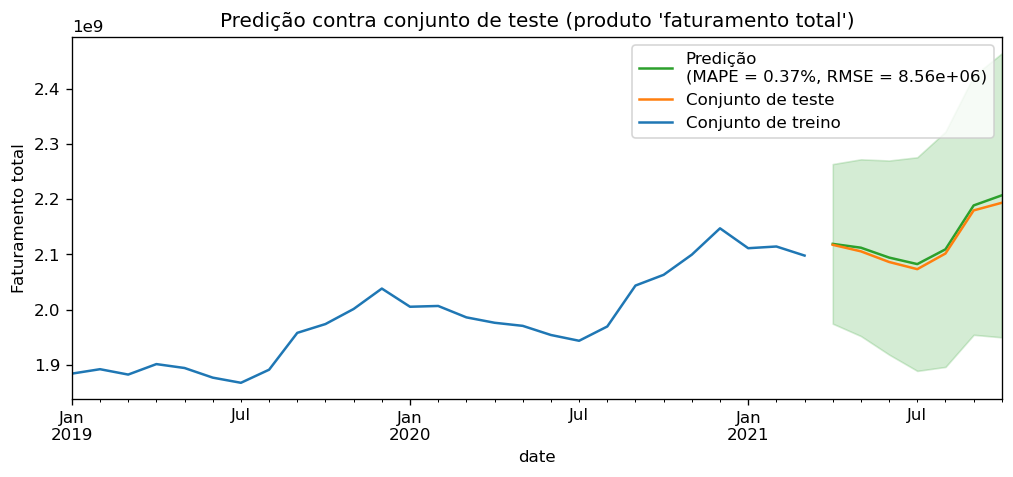

In [11]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_total, 
    produto = 'faturamento total',
    serie_treino = fat_total['2019':'2021-03'],
    serie_teste = fat_total['2021-04':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Por fim, calculamos as métricas associadas a esse conjunto de teste:

In [12]:
metricas = py_scripts.metrics.mostrar_metricas(
    y_true = fat_total[fat_test.index],
    y_pred = fat_test.predicted_mean
)

Métricas:
       MAPE: 0.372%
       RMSE: 8.559e+06
        MAE: 7.914e+06
